In [11]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [12]:
df = pd.read_csv("kag_risk_factors_cervical_cancer.csv")
pd.set_option('display.max_columns', None)

In [13]:
#data imputation

mean_array = ['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes (years)','Smokes (packs/year)','Hormonal Contraceptives (years)','IUD (years)','STDs (number)', 'STDs: Time since first diagnosis','STDs: Time since last diagnosis']
for col in df.columns:
    # target = ['Hinselmann','Schiller','Citology','Biopsy']
    if col in mean_array:
        df[col] = df[col].replace('?',None)
        df[col] = df[col].astype(float)
        mean = df[col].mean(skipna=True)
        df.fillna(mean, inplace=True)
    elif col not in mean_array:
        df[col] = df[col].replace('?',None)
        df[col] = df[col].astype(float)
        mode = df[col].mode()
        df.fillna(mode,inplace=True)

In [14]:
#removing outliers

columns = ['Age', 'Number of sexual partners', 'First sexual intercourse']

# Calculate the IQR for each column and remove outliers
for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df.loc[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

In [15]:
# normalizing the data
columns_to_normalize = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)','STDs: Time since first diagnosis','STDs: Time since last diagnosis']

# Create MinMaxScaler object
for col in columns_to_normalize:
    df[col] = (df[col]-np.min(df[col]))/(np.max(df[col])-np.min(df[col]))

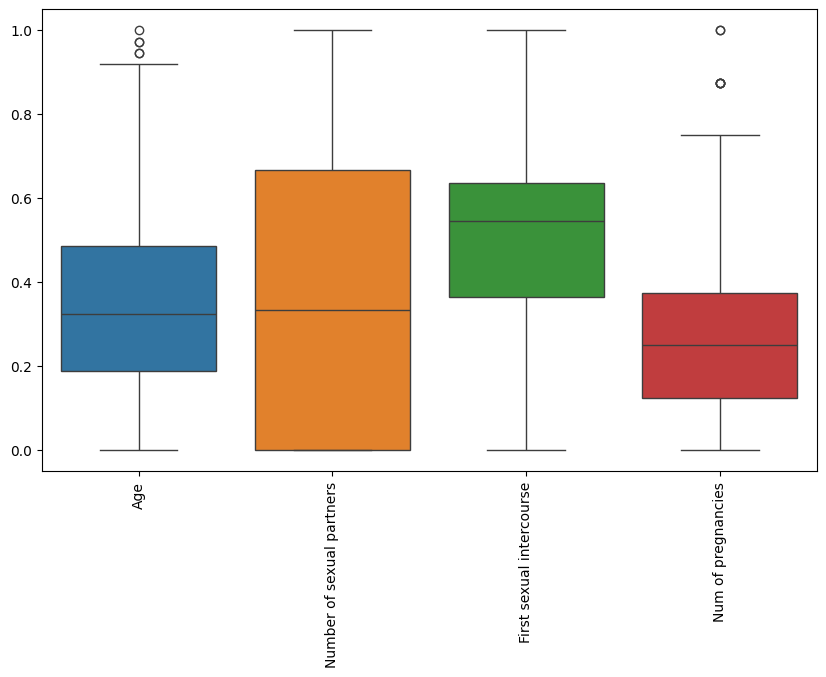

In [16]:
cols_to_plot = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies']

# Create boxplots of the selected columns
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[cols_to_plot], ax=ax)
plt.xticks(rotation=90)
plt.show()

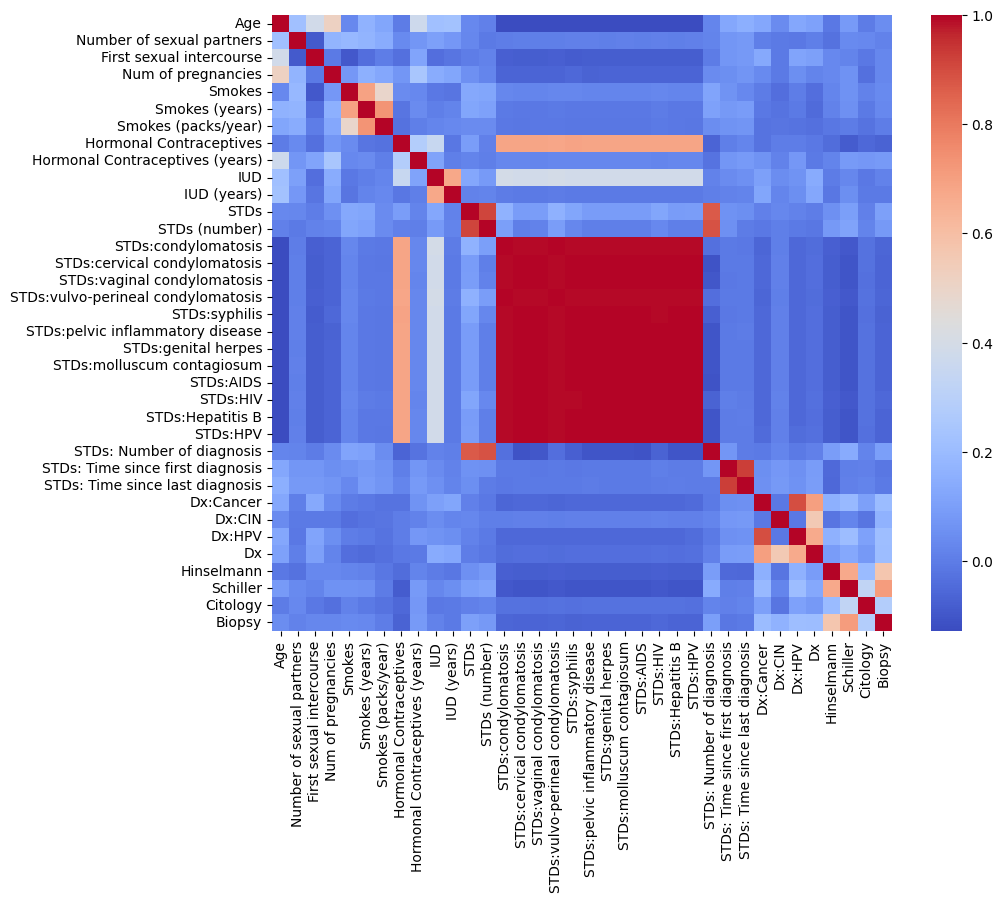

In [17]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a correlation heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [18]:
#PCA
cov_mat = np.cov(df.T)

# Compute the eigenvectors and eigenvalues of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

num_cols = df.drop(columns = ['Hinselmann','Schiller','Citology','Biopsy']).columns

pca = PCA(n_components=15)
X = pd.DataFrame(pca.fit_transform(df[num_cols]))

# Transform the data into the new feature space

# X_1 = X.copy()
Y_1 = df['Hinselmann']

# X_2 = X.copy()
Y_2 = df['Schiller']

# X_3 = X.copy()
Y_3 = df['Citology']

# X_4 = X.copy()
Y_4 = df['Biopsy']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y_2, test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y_3, test_size=0.2, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y_4, test_size=0.2, random_state=42)

# define SMOTE
smote = SMOTE()

# apply SMOTE to the training data
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)
X_train_2, y_train_2 = smote.fit_resample(X_train_2, y_train_2)
X_train_3, y_train_3 = smote.fit_resample(X_train_3, y_train_3)
X_train_4, y_train_4 = smote.fit_resample(X_train_4, y_train_4)


SVM - Validation Accuracy for Hinselmann: 44.666666666666664
SVM - Validation Precision for Hinselmann: 69.76744186046511
SVM - Validation Recall for Hinselmann: 66.66666666666666


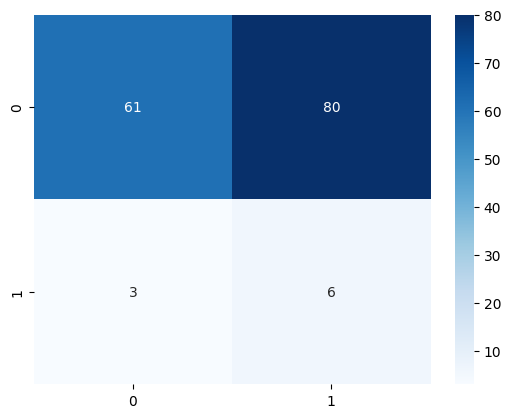



SVM - Validation Accuracy for Schiller: 70.0
SVM - Validation Precision for Schiller: 20.0
SVM - Validation Recall for Schiller: 66.66666666666666


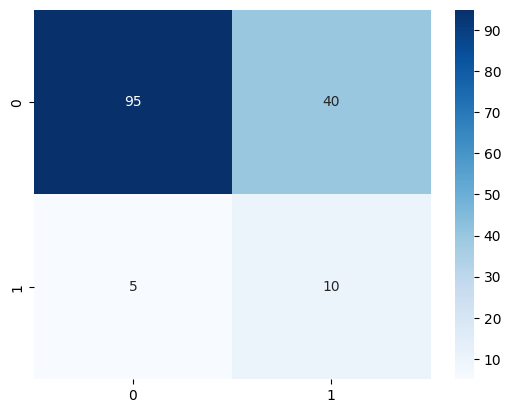



SVM - Validation Accuracy for Citology: 62.66666666666667
SVM - Validation Precision for Citology: 54.54545454545454
SVM - Validation Recall for Citology: 42.857142857142854


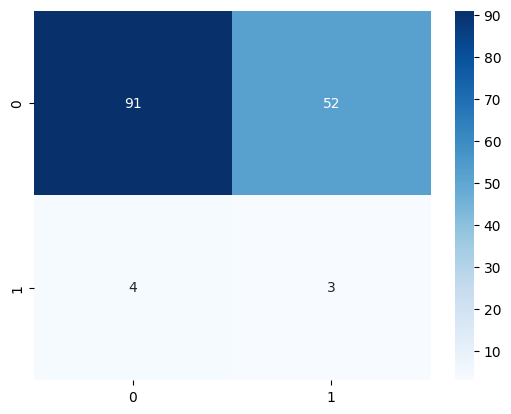



SVM - Validation Accuracy for Biopsy: 60.0
SVM - Validation Precision for Biopsy: 16.417910447761194
SVM - Validation Recall for Biopsy: 73.33333333333333


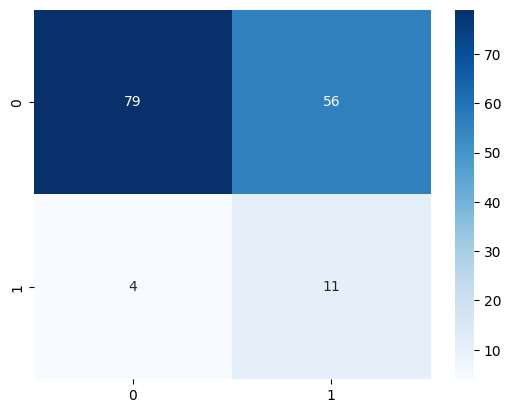



KNN - Validation Accuracy for Hinselmann: 75.33333333333333
KNN - Validation Precision for Hinselmann: 11.11111111111111
KNN - Validation Recall for Hinselmann: 44.44444444444444


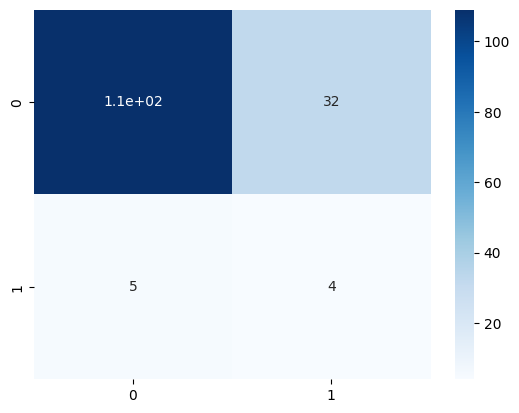



KNN - Validation Accuracy for Schiller: 74.0
KNN - Validation Precision for Schiller: 18.421052631578945
KNN - Validation Recall for Schiller: 46.666666666666664


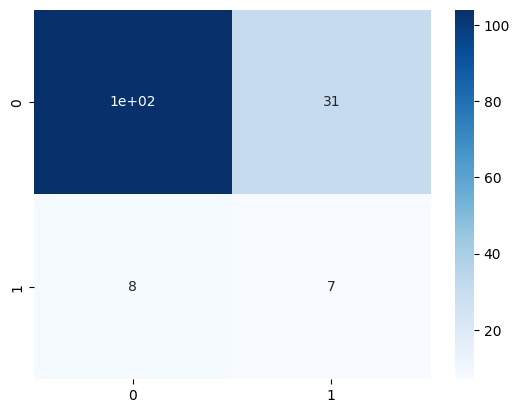



KNN - Validation Accuracy for Citology: 78.66666666666666
KNN - Validation Precision for Citology: 12.121212121212121
KNN - Validation Recall for Citology: 57.14285714285714


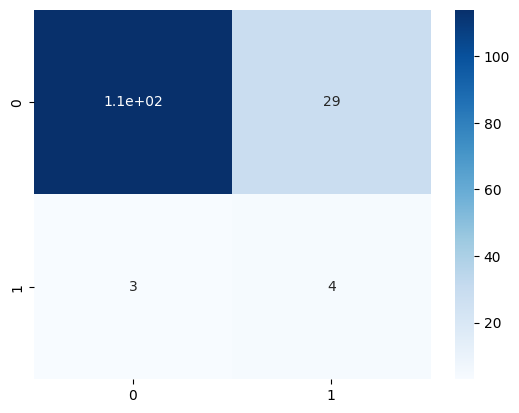



KNN - Validation Accuracy for Biopsy: 76.0
KNN - Validation Precision for Biopsy: 20.0
KNN - Validation Recall for Biopsy: 46.666666666666664


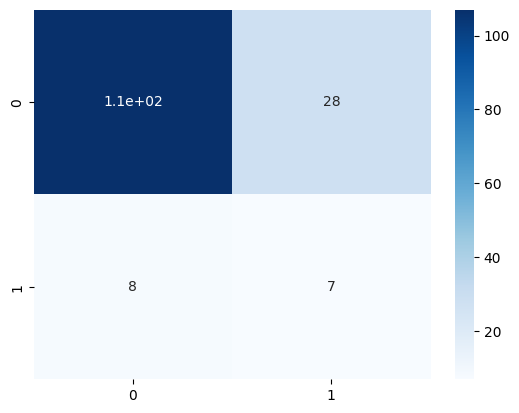

In [19]:
# Train and evaluate the SVM classifier
svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_1, y_train_1)
y_pred_val_svm = svm_clf.predict(X_test_1)
acc_svm = accuracy_score(y_test_1, y_pred_val_svm)
prec_svm = precision_score(y_test_1, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_1, y_pred_val_svm)

print("SVM - Validation Accuracy for Hinselmann:", acc_svm*100)
print("SVM - Validation Precision for Hinselmann:", prec_svm*1000)
print("SVM - Validation Recall for Hinselmann:", rec_svm*100)

cm = confusion_matrix(y_test_1, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_2, y_train_2)
y_pred_val_svm = svm_clf.predict(X_test_2)
acc_svm = accuracy_score(y_test_2, y_pred_val_svm)
prec_svm = precision_score(y_test_2, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_2, y_pred_val_svm)

print("SVM - Validation Accuracy for Schiller:", acc_svm*100)
print("SVM - Validation Precision for Schiller:", prec_svm*100)
print("SVM - Validation Recall for Schiller:", rec_svm*100)

cm = confusion_matrix(y_test_2, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")


svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_3, y_train_3)
y_pred_val_svm = svm_clf.predict(X_test_3)
acc_svm = accuracy_score(y_test_3, y_pred_val_svm)
prec_svm = precision_score(y_test_3, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_3, y_pred_val_svm)

print("SVM - Validation Accuracy for Citology:", acc_svm*100)
print("SVM - Validation Precision for Citology:", prec_svm*1000)
print("SVM - Validation Recall for Citology:", rec_svm*100)
cm = confusion_matrix(y_test_3, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_4, y_train_4)
y_pred_val_svm = svm_clf.predict(X_test_4)
acc_svm = accuracy_score(y_test_4, y_pred_val_svm)
prec_svm = precision_score(y_test_4, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_4, y_pred_val_svm)

print("SVM - Validation Accuracy for Biopsy:", acc_svm*100)
print("SVM - Validation Precision for Biopsy:", prec_svm*100)
print("SVM - Validation Recall for Biopsy:", rec_svm*100)
cm = confusion_matrix(y_test_4, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

# Train and evaluate the KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_1, y_train_1)
y_pred_val_knn = knn_clf.predict(X_test_1)
acc_knn = accuracy_score(y_test_1, y_pred_val_knn)
prec_knn = precision_score(y_test_1, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_1, y_pred_val_knn)

print("KNN - Validation Accuracy for Hinselmann:", acc_knn*100)
print("KNN - Validation Precision for Hinselmann:", prec_knn*100)
print("KNN - Validation Recall for Hinselmann:", rec_knn*100)
cm = confusion_matrix(y_test_1, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_2, y_train_2)
y_pred_val_knn = knn_clf.predict(X_test_2)
acc_knn = accuracy_score(y_test_2, y_pred_val_knn)
prec_knn = precision_score(y_test_2, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_2, y_pred_val_knn)

print("KNN - Validation Accuracy for Schiller:", acc_knn*100)
print("KNN - Validation Precision for Schiller:", prec_knn*100)
print("KNN - Validation Recall for Schiller:", rec_knn*100)
cm = confusion_matrix(y_test_2, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_3, y_train_3)
y_pred_val_knn = knn_clf.predict(X_test_3)
acc_knn = accuracy_score(y_test_3, y_pred_val_knn)
prec_knn = precision_score(y_test_3, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_3, y_pred_val_knn)

print("KNN - Validation Accuracy for Citology:", acc_knn*100)
print("KNN - Validation Precision for Citology:", prec_knn*100)
print("KNN - Validation Recall for Citology:", rec_knn*100)
cm = confusion_matrix(y_test_3, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_4, y_train_4)
y_pred_val_knn = knn_clf.predict(X_test_4)
acc_knn = accuracy_score(y_test_4, y_pred_val_knn)
prec_knn = precision_score(y_test_4, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_4, y_pred_val_knn)

print("KNN - Validation Accuracy for Biopsy:", acc_knn*100)
print("KNN - Validation Precision for Biopsy:", prec_knn*100)
print("KNN - Validation Recall for Biopsy:", rec_knn*100)
cm = confusion_matrix(y_test_4, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")